**IMPORTING THE MODULES**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import load_model, Model
from PIL import Image
import time
import IPython.display as display
from tqdm.notebook import tqdm
from pathlib import Path


In [ ]:
# content_img_path = "https://github.com/hwalsuklee/tensorflow-fast-style-transfer/raw/master/content/chicago.jpg"
# style_img_path = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/300px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"

**DEFINING THE CONTENT AND STYLE IMAGE**

In [ ]:
content_img_path="content.jpg"
style_img_path="style.jpg"

**DEFINING BASIC FUCTIONS**

In [ ]:
def load_image(image_path,max_dim=512):
    img = Image.open(image_path)
    img = img.convert("RGB")
    img.thumbnail([max_dim,max_dim])
    img = np.array(img,dtype=np.float32)
    img = img / 255.0
    img = np.expand_dims(img,axis=0)
    return img

In [ ]:
def deprocess_image(img):
    img = 255*img
    return np.array(img, np.uint8)

In [ ]:
def array_to_img(array, deprocessing=False):
    if deprocessing:
        array=deprocess_image(array)
    if np.ndim(array)>3:
        assert array.shape[0]==1
        array=array[0]
    return Image.fromarray(array)

In [ ]:
def show_image(img, deprocessing=True):
    image=array_to_img(img, deprocessing)
    display.display(image)

(1, 341, 512, 3)


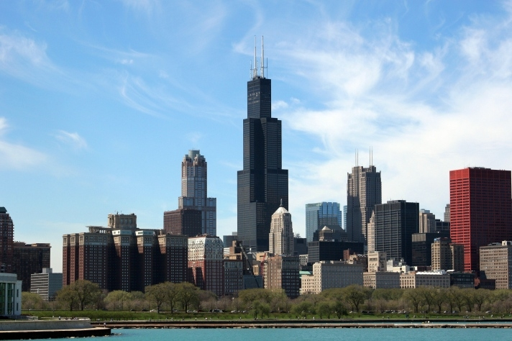

In [ ]:
content_image = load_image(content_img_path)
print(content_image.shape)
show_image(content_image)

(1, 238, 300, 3)


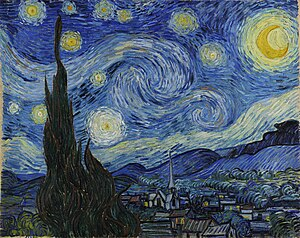

In [ ]:
style_image = load_image(style_img_path)
print(style_image.shape)
show_image(style_image)

In [ ]:
def stylized_model(model, layer_names):
    model.trainable=False
    outputs=[model.get_layer(name).output for name in layer_names]
    new_model=Model(inputs=model.input,outputs=outputs)
    return new_model

**PRETRAINED MODEL**

In [ ]:
vgg=vgg19.VGG19(weights='imagenet',include_top=False)
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**DEFINING CONTENT AND STYLE LAYERS FROM PRETRAINED MODEL**

In [ ]:
content_layers=['block5_conv2']

style_layers=['block1_conv1',
             'block2_conv1',
             'block3_conv1',
             'block4_conv1',
             'block5_conv1']

In [ ]:
content_model = stylized_model(vgg, content_layers)
style_model = stylized_model(vgg, style_layers)

In [ ]:
content_outputs = content_model(content_image)
for layer_name, outputs in zip(content_layers, content_outputs):
    print(layer_name)
    print(outputs.shape)

block5_conv2
(21, 32, 512)


In [ ]:
style_outputs = style_model(style_image)
for layer_name,outputs in zip(style_layers, style_outputs):
    print(layer_name)
    print(outputs.shape)

block1_conv1
(1, 238, 300, 64)
block2_conv1
(1, 119, 150, 128)
block3_conv1
(1, 59, 75, 256)
block4_conv1
(1, 29, 37, 512)
block5_conv1
(1, 14, 18, 512)


**CREATING THE MODEL FOR STYLE TRANSFER**

In [ ]:
model = stylized_model(vgg, style_layers + content_layers)


In [ ]:
def get_output_dict(model, inputs):
    inputs = inputs*255.0
    preprocessed_input = vgg19.preprocess_input(inputs)
    style_length = len(style_layers)
    outputs = model(preprocessed_input)
    style_output,content_output = outputs[:style_length],outputs[style_length:]
    content_dict = {name:value for name,value in zip(content_layers,content_output)}
    style_dict = {name:value for name,value in zip(style_layers,style_output)}
    return {'content':content_dict,'style':style_dict}

In [ ]:
results = get_output_dict(model, style_image)

print("Content Image output Feature maps: ")
for layer_name,output in sorted(results['content'].items()):
    print(layer_name)
    print(output.shape)

for layer_name,output in sorted(results['style'].items()):
    print(layer_name)
    print(output.shape)

Content Image output Feature maps: 
block5_conv2
(1, 14, 18, 512)
block1_conv1
(1, 238, 300, 64)
block2_conv1
(1, 119, 150, 128)
block3_conv1
(1, 59, 75, 256)
block4_conv1
(1, 29, 37, 512)
block5_conv1
(1, 14, 18, 512)


In [ ]:

# Call the function to obtain the dictionary
output_dict = get_output_dict(model, content_image)

# Access the 'content' key from the dictionary
content_targets = output_dict['content']

# Call the function to obtain the dictionary
output_dict = get_output_dict(model, style_image)

# Access the 'style' key from the dictionary
style_targets = output_dict['style']


**LOSS FUNCTIONS**

In [ ]:
def content_loss(placeholder, content):
    return tf.reduce_mean(tf.square(placeholder - content))

In [ ]:
def gram_matrix(x):
    gram=tf.linalg.einsum('bijc,bijd->bcd', x, x)
    return gram/tf.cast(x.shape[1]*x.shape[2],tf.float32)

In [ ]:
def style_loss(placeholder,style):
    s = gram_matrix(style)
    p = gram_matrix(placeholder)
    return tf.reduce_mean(tf.square(s-p))

In [ ]:
def loss_function(outputs, content_outputs, style_outputs, content_weight, style_weight):
    final_content = outputs['content']
    final_style = outputs['style']
    num_style_layers = len(style_layers)
    num_content_layers = len(content_layers)
    # content loss
    # adding content loss from all content_layers and taking its average also multiply with some weighting parameter
    c_loss = tf.add_n([content_loss(content_outputs[name], final_content[name]) for name in final_content.keys()])
    c_loss *= content_weight / num_content_layers
    # style loss
    # adding style loss from all style_layers and taking its average also multiply with some weighting parameter
    s_loss = tf.add_n([style_loss(style_outputs[name], final_style[name]) for name in final_style.keys()])
    s_loss*= style_weight / num_style_layers
    # adding up both content and style loss
    loss = c_loss + s_loss
    return loss

In [ ]:
output_image = tf.Variable(content_image, dtype=tf.float32)


**DEFINING THE OPTIMIZER**

In [ ]:
optimizer=tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)


In [ ]:
def clip_0_1(image):
    return tf.clip_by_value(image,clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
def loss_optimizer(image, optimizer, content_weight, style_weight, total_variation_weight):
    with tf.GradientTape() as tape:
        outputs = get_output_dict(model,image)
        loss = loss_function(outputs, content_targets, style_targets, content_weight, style_weight)
        loss += total_variation_weight * tf.image.total_variation(image)
    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    return loss

**DEFINING WEIGHTS FOR EACH OF THE LOSSES**

In [ ]:
total_variation_weight=0.0004
style_weight=1e-2
content_weight=1e4

**DEFINING THE EPOCH PARAMETERS**

In [ ]:
epochs=10
steps_per_epoch=100

**OPTIMIZING THE OUTPUT IMAGE**

In [ ]:
start=time.time()
for i in range(epochs):
    print(f"Epoch: {i+1}")
    for j in tqdm(range(steps_per_epoch)):
        curr_loss = loss_optimizer(output_image, optimizer, content_weight, style_weight, total_variation_weight)
        # we can save image in every step here
        # current_image = array_to_img(output_image.numpy(), deprocessing=True)
        # current_image.save(f'progress/{i}_{j}_paint.jpg')
    print(f"Loss: {curr_loss}")
end=time.time()
print(f"Image successfully generated in {end-start:.1f} sec")

Epoch: 1


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: [16888666.]
Epoch: 2


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: [9861160.]
Epoch: 3


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: [7225875.]
Epoch: 4


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: [5945679.]
Epoch: 5


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: [5215621.5]
Epoch: 6


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: [4758559.]
Epoch: 7


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: [4457030.5]
Epoch: 8


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: [4244266.5]
Epoch: 9


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: [4083107.8]
Epoch: 10


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: [3958982.]
Image successfully generated in 10941.0 sec


**SAVING THE OUTPUT IMAGE**

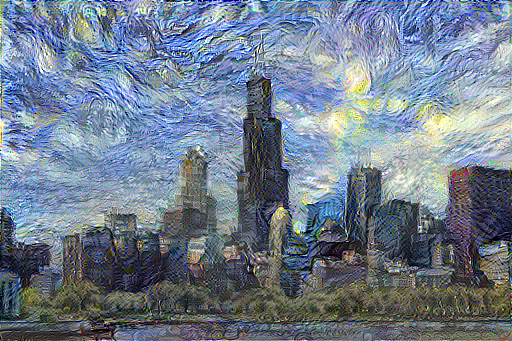

In [ ]:
show_image(output_image.numpy(), deprocessing=True)
final_image = array_to_img(output_image.numpy(), deprocessing=True)
final_image.save("output.jpg")